## RecSys Tutorial for the EvalRS 2023 hackaton 
# Retrieval models with Merlin and Tensorflow on LastFM dataset

In this notebook, we present a tutorial on how to use the open-source [NVIDIA Merlin](https://github.com/NVIDIA-Merlin/) framework, on top of Tensorflow, to build and train a retrieval model for EvalRS hackaton using LastFM dataset. It uses the [NVTabular](https://github.com/NVIDIA-Merlin/NVTabular) library for preprocessing and [Merlin Models](https://github.com/NVIDIA-Merlin/models) library for building and training Tensorflow-based retrieval models.

**IMPORTANT**: This notebook requires a **GPU** to run the NVTabular pipeline. If your environment does not have a GPU, you might want to use the [Google Colab](https://colab.research.google.com/drive/1Ftl2B7BVFMfFjyjWweFCP_gA_LdCl7-a?usp=sharing) version of this notebook.

### Retrieval models and Two-stage RecSys
Retrieval models are recsys scalable models that are able to retrieve a large number of candidate items for recommendation. They are typically used in two-stage recsys pipelines, where the retrieval stage scores hundreds of thousands or millions of items and then the ranking stage model rescores the candidate items, using for that more features or with a more powerful architecture.  
For ML-based candidate retrieval model, as it needs to quickly score millions of items for a given user, the retrieval models typically produce recommendation scores by just computing the dot product between user and item representations. Popular choices of such models are Matrix Factorization, which learns low-rank user and item embeddings, and the Two-Tower architecture, which is a neural network with two MLP towers where both user and item features are fed to generate user and item embeddings in the output.  

In this notebook you will learn how to implement a pipeline for the hackaton that preprocess the available categorical, continuous and the song lyrics pre-trained embedding features in a suitable format for neural networks and trains retrieval models (Matrix Factorization and Two-Tower architecture).

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import shutil
from functools import partial
sys.path.append(os.path.abspath('../../evaluation'))

from EvalRSRunner import ChallengeDataset
from EvalRSReclist import EvalRSReclist
from reclist.reclist import LOGGER, METADATA_STORE
from merlin.io.dataset import Dataset

2023-08-01 02:11:36.974625: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 02:11:37.011474: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/torch.py:43: UserWarning: PyTorch dtype mappings did not load successfully due to an error: No module named 'torch'
  warn(f"PyTorch dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
# If None the dataset will be saved to a temporary cache folder
DATASET_OUT_PATH = '/data'

In [3]:
PREPROC_DATASET_OUT_PATH = os.path.join(DATASET_OUT_PATH, "evalrs_2023_dataset_preproc")
CATEG_MAPPING_FOLDER = os.path.join(PREPROC_DATASET_OUT_PATH, 'categories/')

## Dataset download and split

Let's first download and uncompress the dataset and all its tables.  
In order to reduce the dataset for faster and less memory intensive computation, we set `sample_users_perc=0.25` to sample 25% of the users and keep only their events. We also set `min_user_item_freq=10` so that we have users and items with a mininum frequency of 10.

In [4]:
# note, if YES, the dataset will be donwloaded again
dataset = ChallengeDataset(force_download=False, 
                           dataset_out_path=DATASET_OUT_PATH,
                           folded_dataset_split = False,
                           sample_users_perc=0.25,
                           min_user_item_freq=10)  

LFM dataset already downloaded. Skipping download.
Loading dataset.
Generating dataset hashes.


The test set is defined as the last interaction for each user. So all users and items in test set are present in test set, as we are not focused in exploring the user/item cold-start problem in this example of music streaming domain.

In [5]:
events_train_df, events_test_df = dataset._get_train_set(), dataset._get_test_set()
print(len(events_train_df), len(events_test_df))

6869679 29722


## Preprocessing

**If you have already processed the dataset you can skip this section, as the parquet files were already generated in `PREPROC_DATASET_OUT_PATH`**

In [6]:
import nvtabular as nvt
import nvtabular.ops as ops
from merlin.dag import ColumnSelector
from merlin.schema import Schema, Tags

In [7]:
len(events_train_df)

6869679

In [8]:
len(events_test_df)

29722

In [9]:
class Preprocessor:
    
    def events_join_tables(self, events_df):
        events_df = events_train_df.copy()    
        del events_df["timestamp"]
        del events_df["artist_id"]
        del events_df["user_track_count"]    

        users_df = dataset.df_users.copy()
        del users_df["registered_unixtime"]
        del users_df["country_id"]
        del users_df["gender_id"]

        tracks_df = dataset.df_tracks.copy()
        del tracks_df["artist"]
        del tracks_df["albums_id"]
        del tracks_df["albums"]

        social_tags_df = dataset.df_social_tags.reset_index()
        social_tags_df = social_tags_df[social_tags_df["social_tags_weight"] > 5]
        social_tags_df = social_tags_df.groupby('lastfm_id').agg({"social_tags_value": list})
        

        emotion_tags_df = dataset.df_emotion_tags.reset_index()
        emotion_tags_df = emotion_tags_df[emotion_tags_df["emotion_tags_weight"] > 5]
        emotion_tags_df = emotion_tags_df.groupby('lastfm_id').agg({"emotion_tags_value": list})        


        event_enriched_df = events_df \
                .merge(users_df, left_on="user_id", right_index=True) \
                .merge(tracks_df, left_on="track_id", right_index=True) \
                .merge(emotion_tags_df, left_on="lastfm_id", right_index=True, how="left") \
                .merge(social_tags_df, left_on="lastfm_id", right_index=True, how="left")
        event_enriched_df["social_tags_value"] = event_enriched_df["social_tags_value"].apply(lambda x: x if x and x is not np.nan else ["<null>"])
        event_enriched_df["emotion_tags_value"] = event_enriched_df["emotion_tags_value"].apply(lambda x: x if x and x is not np.nan else ["<null>"])

        return event_enriched_df


    def get_nvtabular_preproc_workflow(self):
        """Defines an NVTabular preprocessing workflow"""

        user_id_col = ["user_id"] 
        user_cat_cols = ["country", "gender"]
        user_age_col = ["age"]

        user_continuous_cols = [
            'novelty_artist_avg_month', 'novelty_artist_avg_6months', 'novelty_artist_avg_year',
            'mainstreaminess_avg_month', 'mainstreaminess_avg_6months', 'mainstreaminess_avg_year', 'mainstreaminess_global',
            'relative_le_per_weekday1', 'relative_le_per_weekday2', 'relative_le_per_weekday3',
             'relative_le_per_weekday4', 'relative_le_per_weekday5','relative_le_per_weekday6', 'relative_le_per_weekday7',
             'relative_le_per_hour0', 'relative_le_per_hour1','relative_le_per_hour2', 'relative_le_per_hour3',
             'relative_le_per_hour4', 'relative_le_per_hour5', 'relative_le_per_hour6', 'relative_le_per_hour7', 
             'relative_le_per_hour8', 'relative_le_per_hour9', 'relative_le_per_hour10', 'relative_le_per_hour11',
             'relative_le_per_hour12', 'relative_le_per_hour13', 'relative_le_per_hour14', 'relative_le_per_hour15',
             'relative_le_per_hour16', 'relative_le_per_hour17','relative_le_per_hour18', 'relative_le_per_hour19',
             'relative_le_per_hour20', 'relative_le_per_hour21', 'relative_le_per_hour22', 'relative_le_per_hour23', 
        ]

        user_counts_cols = ['playcount', 'cnt_listeningevents', 'cnt_distinct_tracks', 
                                'cnt_distinct_artists', 'cnt_listeningevents_per_week']

        item_id = ["track_id"]
        item_categ_features_cols = ["artist_id", "album_id",
                                    'has_emotion_tags', 'has_social_tags', 'isClassic',
                                    'emotion_tags_value', 'social_tags_value',
                                    "urlSong" # Just for making it possible to join the pre-trained embeddings later
                                   ] 
        item_cont_features_cols = ['arousal_predicted', 'valence_predicted']

        user_id = user_id_col >> ops.Categorify(out_path=PREPROC_DATASET_OUT_PATH) >> ops.TagAsUserID()
        user_feat_cat = user_cat_cols >> ops.Categorify(out_path=PREPROC_DATASET_OUT_PATH) >> ops.TagAsUserFeatures()
        age_boundaries = list(np.arange(0,100,5))
        user_age = user_age_col >> ops.FillMissing(0) >> ops.Bucketize(age_boundaries) >> ops.Categorify(out_path=PREPROC_DATASET_OUT_PATH) >> ops.TagAsUserFeatures()
        user_feat_cont = user_continuous_cols >> ops.FillMedian() >> ops.Normalize() >> ops.TagAsUserFeatures()
        user_feat_count = user_counts_cols >> ops.Clip(min_value=1) >> ops.FillMedian() >> ops.LogOp() >> ops.Normalize() >> ops.TagAsUserFeatures()
        user_features = user_id + user_feat_cat + user_age + user_feat_cont + user_feat_count

        item_id = item_id >> ops.Categorify(out_path=PREPROC_DATASET_OUT_PATH) >> ops.TagAsItemID()
        item_cat_feat = item_categ_features_cols >> ops.Categorify(out_path=PREPROC_DATASET_OUT_PATH) >> ops.TagAsItemFeatures()
        item_cont_feat = item_cont_features_cols >> ops.FillMedian() >> ops.Normalize() >> ops.TagAsItemFeatures()
        item_features = item_id + item_cat_feat + item_cont_feat

        outputs = user_features + item_features
        workflow = nvt.Workflow(outputs)
        return workflow

    def preprocess_dataset(self, events_df, output_path):
        """Preprocess the dataset using an NVTabular workflow"""        
        nvt_dataset = nvt.Dataset(events_df)
        
        shutil.rmtree(CATEG_MAPPING_FOLDER, ignore_errors=True)

        nvt_workflow = self.get_nvtabular_preproc_workflow()
        nvt_workflow.fit(nvt_dataset)
        schema = nvt_workflow.output_schema

        transformed_dataset = nvt_workflow.transform(nvt_dataset)        
        transformed_dataset.to_parquet(output_path)

#### Joining the train set with auxiliary tables

The next cell joins the events with the auxiliary tables (e.g. users, tracks, emotions, topics, etc), so that it forms a single train set.

In [10]:
preprocessor = Preprocessor()
events_train_enriched_df = preprocessor.events_join_tables(events_train_df)
events_train_enriched_df

,user_id,album_id,track_id,country,age,gender,playcount,novelty_artist_avg_month,novelty_artist_avg_6months,novelty_artist_avg_year,...,artist_id,urlSong,arousal_predicted,valence_predicted,lastfm_id,has_emotion_tags,has_social_tags,isClassic,emotion_tags_value,social_tags_value
1,50967444,114114,336156,None,16,n,262,0.263945,0.059712,0.512946,...,3059,http://lyrics.wikia.com/Sufjan_Stevens:Tahquam...,-0.076169,-0.118055,TRTSJVD128F427EEF4,True,True,False,"[mellow, relaxing, soothing]","[indie, instrumental, folk, mellow, alternativ..."
49099,49932292,114114,336156,ES,25,f,777,0.517772,0.121765,0.380952,...,3059,http://lyrics.wikia.com/Sufjan_Stevens:Tahquam...,-0.076169,-0.118055,TRTSJVD128F427EEF4,True,True,False,"[mellow, relaxing, soothing]","[indie, instrumental, folk, mellow, alternativ..."
98471,49844991,310428,336156,None,-1,n,77,0.281976,0.053891,0.485772,...,3059,http://lyrics.wikia.com/Sufjan_Stevens:Tahquam...,-0.076169,-0.118055,TRTSJVD128F427EEF4,True,True,False,"[mellow, relaxing, soothing]","[indie, instrumental, folk, mellow, alternativ..."
635664,49315469,200774,336156,None,-1,n,997,0.366650,0.041330,0.546916,...,3059,http://lyrics.wikia.com/Sufjan_Stevens:Tahquam...,-0.076169,-0.118055,TRTSJVD128F427EEF4,True,True,False,"[mellow, relaxing, soothing]","[indie, instrumental, folk, mellow, alternativ..."
1162136,48657342,310428,336156,None,-1,n,1930,0.233702,0.103151,0.553339,...,3059,http://lyrics.wikia.com/Sufjan_Stevens:Tahquam...,-0.076169,-0.118055,TRTSJVD128F427EEF4,True,True,False,"[mellow, relaxing, soothing]","[indie, instrumental, folk, mellow, alternativ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6665266,3385917,4815497,10504230,US,40,m,95522,0.292078,0.030747,0.518262,...,5304,None,NaN,NaN,None,None,None,None,[<null>],[<null>]
6767652,2689446,4815497,10504230,UK,34,m,143799,0.637427,0.031232,0.749870,...,5304,None,NaN,NaN,None,None,None,None,[<null>],[<null>]
6770998,2670686,6215198,10504230,None,-1,n,28180,0.477809,0.069842,0.575084,...,5304,None,NaN,NaN,None,None,None,None,[<null>],[<null>]
6805537,2508901,4815497,10504230,US,31,m,75859,0.200235,0.097100,0.345057,...,5304,None,NaN,NaN,None,None,None,None,[<null>],[<null>]


#### Preprocess the dataset with NVTabular and export to parquet files

For preprocessing, we use the [NVTabular](https://github.com/NVIDIA-Merlin/NVTabular) library, which provides very handful features for common operations like (label) encoding categorical features for embeddings and normalization for continuous features. NVTabular works both with CPUs and GPUs. 
The output parquet files will be saved to `PREPROC_DATASET_OUT_PATH` folder

In [11]:
preprocessor.preprocess_dataset(events_train_enriched_df, 
                                output_path=PREPROC_DATASET_OUT_PATH)

## Loading the preprocesset dataset

In [12]:
train_ds = Dataset(os.path.join(PREPROC_DATASET_OUT_PATH, '*.parquet'))

In [13]:
train_ds.to_ddf().head()

,user_id,country,gender,age,novelty_artist_avg_month,novelty_artist_avg_6months,novelty_artist_avg_year,mainstreaminess_avg_month,mainstreaminess_avg_6months,mainstreaminess_avg_year,...,artist_id,album_id,has_emotion_tags,has_social_tags,isClassic,emotion_tags_value,social_tags_value,urlSong,arousal_predicted,valence_predicted
0,10832,2,3,5,-0.626581,0.813531,0.090792,1.572557,0.848605,0.585004,...,204,18709,3,3,3,"[4, 13, 28]","[7, 65, 30, 20, 5, 2666, 42, 1666, 2414, 846, ...",54956,-0.189828,0.367678
1,5670,1,5,6,0.748759,3.807387,-0.588009,-1.421893,-0.751658,0.203650,...,204,18709,1,1,3,"[4, 13, 28]","[7, 65, 30, 20, 5, 2666, 42, 1666, 2414, 846, ...",54956,-0.189828,0.367678
2,12052,1,3,3,-0.528880,0.532691,-0.048953,-0.158593,1.100500,-1.213415,...,204,5670,1,1,3,"[4, 13, 28]","[7, 65, 30, 20, 5, 2666, 42, 1666, 2414, 846, ...",54956,-0.189828,0.367678
3,10640,1,3,3,-0.070079,-0.073335,0.265490,0.195524,-0.748907,-0.383778,...,204,24082,1,1,1,"[4, 13, 28]","[7, 65, 30, 20, 5, 2666, 42, 1666, 2414, 846, ...",1,-0.189828,0.367678
4,6594,1,3,3,-0.790451,2.909314,0.298523,0.167329,-0.753980,0.618950,...,204,5670,1,1,3,"[4, 13, 28]","[7, 65, 30, 20, 5, 2666, 42, 1666, 2414, 846, ...",54956,-0.189828,0.367678


In [14]:
# Loads mapping of categ features after the workflow is fit
user_ids_mapping_df = pd.read_parquet(os.path.join(CATEG_MAPPING_FOLDER, 'unique.user_id.parquet'))[['user_id']]
track_ids_mapping_df = pd.read_parquet(os.path.join(CATEG_MAPPING_FOLDER, 'unique.track_id.parquet'))[['track_id']]
url_song_ids_mapping_df = pd.read_parquet(os.path.join(CATEG_MAPPING_FOLDER, 'unique.urlSong.parquet'))[['urlSong']]

### Preparing Songs lyrics embeddings

This section prepares a matrix with the song lyrics pre-trained embeddings. It can be used by the Two-Tower model as an item feature.

In [15]:
song_embeddings_df = dataset.df_song_embeddings.merge(url_song_ids_mapping_df.reset_index().rename({"index": "url_song_index"}, axis=1),
                                 on="urlSong").set_index("url_song_index").sort_index()
del song_embeddings_df["urlSong"]
song_embeddings_df

,song_embedding
url_song_index,
3,"[0.040728766, 0.028635837, -0.010818669, -0.08..."
4,"[-0.00038573408, 0.015808051, -0.017853128, -0..."
5,"[0.00045647967, 0.08925042, 0.038907174, -0.03..."
6,"[-0.034443233, -0.011341039, 0.008480853, -0.0..."
7,"[0.04746266, 0.048200216, 0.02619298, 0.020876..."
...,...
146616,"[0.026716162, -0.069737315, 0.018002456, 0.038..."
146617,"[0.005791276, -4.8687336e-05, 0.01080327, -0.0..."
146619,"[0.032971963, 0.014805067, 0.0059817433, -0.02..."


In [16]:
avg_embedding = np.vstack(song_embeddings_df['song_embedding'].values).mean(axis=0)

In [17]:
song_embeddings_df = song_embeddings_df.reindex(np.arange(song_embeddings_df.index.max()+1), 
                                                fill_value=avg_embedding)

In [18]:
song_embeddings_df

,song_embedding
url_song_index,
0,"[0.021221787, 0.029759321, 0.0013067338, -0.01..."
1,"[0.021221787, 0.029759321, 0.0013067338, -0.01..."
2,"[0.021221787, 0.029759321, 0.0013067338, -0.01..."
3,"[0.040728766, 0.028635837, -0.010818669, -0.08..."
4,"[-0.00038573408, 0.015808051, -0.017853128, -0..."
...,...
146617,"[0.005791276, -4.8687336e-05, 0.01080327, -0.0..."
146618,"[0.021221787, 0.029759321, 0.0013067338, -0.01..."
146619,"[0.032971963, 0.014805067, 0.0059817433, -0.02..."


In [19]:
song_lyrics_embedding_matrix = np.vstack(song_embeddings_df["song_embedding"])
song_lyrics_embedding_matrix.shape

(146622, 768)

In [20]:
del song_embeddings_df

## Creates a retrieval recsys pipeline with Merlin

In [21]:
import merlin.models.tf as mm
from merlin.io import Dataset
from merlin.io.dataset import Dataset
from merlin.schema.tags import Tags
from merlin.models.utils import schema_utils
from merlin.models.tf.transforms.bias import PopularityLogitsCorrection
from merlin.models.tf.outputs.base import DotProduct
from merlin.models.utils.dataset import unique_rows_by_features
from merlin.dataloader.ops.embeddings import EmbeddingOperator
import tensorflow as tf
from tensorflow.keras import regularizers

[INFO]: sparse_operation_kit is imported
[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.2.0-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so
[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.2.0-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so
[SOK INFO] Initialize finished, communication tool: horovod


2023-08-01 02:12:51.694743: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-01 02:12:51.694782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16254 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:15:00.0, compute capability: 7.0
2023-08-01 02:12:51.696751: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-01 02:12:51.696774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 16254 MB memory:  -> device: 1, name: Quadro GV100, pci bus id: 0000:2d:00.0, compute capability: 7.0
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarn

In [22]:
def get_item_frequencies(train_ds):       
    """Utility function that returns a TF tensor with the items (tracks) frequency"""
    schema = train_ds.schema
    # Gets the item ids cardinality
    item_id_feature = schema.select_by_tag(Tags.ITEM_ID)
    item_id_feature_name = item_id_feature.column_names[0]
    cardinalities = schema_utils.categorical_cardinalities(schema)
    item_id_cardinality = cardinalities[item_id_feature_name]

    item_id_feature_name = schema.select_by_tag(Tags.ITEM_ID).column_names[0]

    item_frequencies_df = (
        train_ds.to_ddf()
        .groupby(item_id_feature_name)
        .size()
        .to_frame("freq")
        .compute()
    )
    assert len(item_frequencies_df) <= item_id_cardinality
    assert item_frequencies_df.index.max() < item_id_cardinality

    # Completing the missing item ids and filling freq with 0
    item_frequencies_df = item_frequencies_df.reindex(
        np.arange(0, item_id_cardinality)
    ).fillna(0)
    assert len(item_frequencies_df) == item_id_cardinality

    item_frequencies_df = item_frequencies_df.sort_index()
    item_frequencies_df["dummy"] = 1
    item_frequencies_df["expected_id"] = item_frequencies_df["dummy"].cumsum() - 1
    assert (
        item_frequencies_df.index == item_frequencies_df["expected_id"]
    ).all(), f"The item id feature ({item_id_feature_name}) should be contiguous from 0 to {item_id_cardinality-1}"

    item_frequencies = tf.convert_to_tensor(
        item_frequencies_df["freq"].values.get()
    )

    return item_frequencies

### Merlin Models
For model definition and training we use [Merlin Models](https://github.com/NVIDIA-Merlin/models). It provides a Tensorflow (Keras) API where you can easily build state-of-the-art retrieval and ranking models. One of the core ideas of Models is to leverage the schema generated during preprocessing by **NVTabular** to create automatically the necessary embedding tables for categorical features and define the target of the model.  You can find more information about retrieval with Merlin Models in this [example notebook](https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb).

Here we will be implementing two retrieval models: **Matrix Factorization** and **Two-Tower architecture**.
You will notice that we create a base `MyRetrievalModel` class, which we specialize later as `MyMFModel` and `MyTwoTowerModel` to override the `get_model()` method to return a `MatrixFactorizationModel` or `TwoTowerModel` instance.

### Defining your RecModel

Here we define our `RecModel` for EvalRS, which must implement the `train()` and the `predict()` methods. Within `train()` we receive a dataframe with the fold data and we need to define our full pipeline for preprocessing and training data. The `predict()` method receives a dataframe with the user ids, and it expects you to return the top-k predicted items for each user.

In [23]:
class MyRetrievalModel():
    
    def __init__(self, user_ids_mapping_df, track_ids_mapping_df,
                 pretrained_embeddings=None,
                 top_k: int = 100, 
                 predict_batch_size=1024, 
                 **kwargs):
        self.user_ids_mapping_df = user_ids_mapping_df
        self.track_ids_mapping_df = track_ids_mapping_df
        self.pretrained_embeddings = pretrained_embeddings
        self.top_k = top_k
        self.predict_batch_size = predict_batch_size
        self.hparams = kwargs
    
        
    def get_retrieval_output(self):        
        """Defines the item retrieval task to be used by the retrieval models"""
        items_frequencies = get_item_frequencies(self.train_dataset)
        
        post_logits = None
        reg_factor = self.hparams['logq_correction_factor']
        if reg_factor > 0.0:
            post_logits = PopularityLogitsCorrection(
                items_frequencies,
                reg_factor=reg_factor,
                schema=self.schema,
            )
            
        
        retrieval_output = mm.ContrastiveOutput(
            DotProduct(),
            logits_temperature=self.hparams['logits_temperature'],
            post=post_logits,
            negative_samplers="in-batch",
            schema=self.schema,
            store_negative_ids=True,
        )
        
        return retrieval_output

    
    def get_model(self):
        """Defines the model architecture. Needs to be overridden by the child class"""
        raise NotImplementedError()
    
    def compile_model(self, model):
        """Compiles the Keras model setting the metrics, loss, learning rate and optimizer"""
        metrics = [mm.TopKMetricsAggregator(mm.RecallAt(20), mm.MRRAt(20))]
        
        lerning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            self.hparams['lr'],
            decay_steps=self.hparams['lr_decay_steps'],
            decay_rate=self.hparams['lr_decay_rate'],
            staircase=True,
        )
        optimizer = tf.keras.optimizers.Adam(learning_rate=lerning_rate)
        loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=self.hparams['label_smoothing'],
        )
        
        model.compile(optimizer, loss=loss, metrics=metrics, run_eagerly=False)
        
    def get_items_topk_recommender_model(
        self,
        dataset, 
        loader_transforms,
        model, 
        ):        
        """Converts a retrieval model into a Top-k recommender model, which
        takes only user features as input, generates the user representations 
        (e.g. by taking the user embedding for MF or using the user tower to generate it)
        and uses scores all cached item representations to return the most similar items 
        (P.s. This procedure would be done by an ANN engine in production)"""        
        candidate_features = unique_rows_by_features(dataset, Tags.ITEM, Tags.ITEM_ID)
        loader_candidates = mm.Loader(
            candidate_features,
            batch_size=128,
            transforms=loader_transforms,
        )

        topk_rec_model = model.to_top_k_encoder(loader_candidates, k=self.top_k, batch_size=128)

        return topk_rec_model
        
    def train_model(self, model, loader):
        model.fit(
            loader,
            epochs=self.hparams['epochs'],            
            #steps_per_epoch=10,
            shuffle=True,
            drop_last=True,
            train_metrics_steps=10,
        )
        

    def train(self, train_dataset: Dataset):
        """
        Implement here your training logic. Since our example method is a simple random model,
        we actually don't use any training data to build the model, but you should ;-)
        At the end of training, make sure the class contains a trained model you can use in the predict method.
        """                    
            
        self.train_dataset = train_dataset        

        loader_transforms = None
        if self.pretrained_embeddings is not None:
            loader_transforms = [
                EmbeddingOperator(
                    self.pretrained_embeddings,
                    lookup_key="urlSong",
                    embedding_name="pretrained_item_lyrics_emb",
                )]
            
        loader = mm.Loader(
            train_dataset,
            batch_size=self.hparams['train_batch_size'],
            transforms=loader_transforms
        )
        self.schema = loader.output_schema
        
        print("Building the model")
        model = self.get_model()
        print(model)
        self.compile_model(model)        
        
        print("Start training")
        self.train_model(model, loader)        
        self.trained_model = model
        
        print("Preparing retrieval model for prediction")
        self.topk_rec_model = self.get_items_topk_recommender_model(train_dataset, loader_transforms, model)
        
        #print("Debugging: Evaluating on train set")
        #self.topk_rec_model.compile(run_eagerly=False)
        #metrics = self.topk_rec_model.evaluate(loader, batch_size=256, return_dict=True)
        #print(metrics)
        
        print("Caching users transformed features")
        self.users_schema = self.schema.select_by_tag(Tags.USER)
        user_features = self.users_schema.column_names
        self.users_transformed_df = train_dataset.to_ddf()[user_features].drop_duplicates(subset=['user_id'], keep='last').compute().to_pandas()
        # Adding the raw (original) user id to the dataframe
        self.users_transformed_df = self.users_transformed_df.merge(self.user_ids_mapping_df.rename({'user_id': 'raw_user_id'}, axis=1),
                                                                    left_on='user_id', right_index=True)

        print("Training completed!")         

    def predict(self, user_ids: pd.DataFrame) -> pd.DataFrame:
        """        
        This function takes as input all the users that we want to predict the top-k items for, and 
        returns all the predicted songs.

        While in this example is just a random generator, the same logic in your implementation 
        would allow for batch predictions of all the target data points.        
        """
            
        self.predict_user_ids = user_ids
        
        print("Start prediction")
        print("# users:",len(user_ids))
        test_users_df = user_ids.rename({'user_id': 'raw_user_id'}, axis=1).merge(self.users_transformed_df, 
                                                       on='raw_user_id', how='left')
        self.test_users_df = test_users_df
        test_users_found_df = test_users_df[~test_users_df[test_users_df.columns[1]].isna()]
        test_users_not_found_df = test_users_df[test_users_df[test_users_df.columns[1]].isna()]        

        test_users_dataset = Dataset(test_users_found_df, self.users_schema)
        test_batched_dataset = mm.Loader(
            test_users_dataset, batch_size=self.predict_batch_size, shuffle=False, schema=self.users_schema
        )        
        
        print(f"Predicting Top-{self.top_k} items for test users")
        predictions = self.topk_rec_model.predict(test_batched_dataset)[1].astype(np.int32) 
        
        print(f"Converting user ids and predicted item ids to the original ids")
        predictions_converted = self.convert_prediction_item_ids(predictions)
        
        user_ids_found_converted = test_users_found_df['raw_user_id'].values.astype(np.int32)        
        user_ids_not_found_converted = test_users_not_found_df['raw_user_id'].values.astype(np.int32)
        
        # Merging raw user id with top-k predictions
        user_predictions_found_converted = np.concatenate((np.expand_dims(user_ids_found_converted, -1), predictions_converted), axis=1)
        user_predictions_not_found_converted = np.concatenate((np.expand_dims(user_ids_not_found_converted, -1), 
                                                               np.zeros((user_ids_not_found_converted.shape[0], predictions_converted.shape[1]))), axis=1)
        # Combining predictions of users found and not found
        user_predictions_converted = np.vstack([user_predictions_found_converted, user_predictions_not_found_converted])        
        user_predictions_df = pd.DataFrame(user_predictions_converted, columns=['user_id', *[str(i) for i in range(predictions_converted.shape[1])]]).astype(np.int32).set_index('user_id')
        # Ensures predictions output dataframe is sorted the same as input user_ids order
        user_predictions_df = user_predictions_df.loc[user_ids['user_id'].values]
        self.user_predictions_df = user_predictions_df
        print("Finish prediction")
        return user_predictions_df
    
    def convert_user_ids(self, user_ids):
        """Converts the encoded user ids into the original ids"""
        raw_user_ids = self.user_ids_mapping_df['user_id'].loc[user_ids].values
        return raw_user_ids
    
    def convert_prediction_item_ids(self,predictions):
        """Converts the encoded predicted item ids into the original item ids"""
        raw_topk_predicted_item_ids = self.track_ids_mapping_df['track_id'].loc[predictions.reshape(-1)].values
        raw_topk_predicted_item_ids = np.reshape(raw_topk_predicted_item_ids, (-1, predictions.shape[1]))
        return raw_topk_predicted_item_ids

In [24]:
def export_preds(preds_df, filename):
    output_path = os.path.join(PREPROC_DATASET_OUT_PATH, "model_predictions")
    os.makedirs(output_path, exist_ok=True)
    preds_df.to_parquet(os.path.join(output_path, filename))

In [25]:
def compute_recall(user_preds_df):
    preds_with_target = events_test_df.set_index("user_id").merge(user_preds_df, left_index=True, right_index=True)
    recall_at_100 = np.equal(np.expand_dims(preds_with_target["track_id"].values, -1), preds_with_target[[f"{i}" for i in range(100)]].values).max(axis=1).mean()
    return recall_at_100

In [34]:
# Importing a similarity model from GenSim for the RecList "Being Less Wrong" metric
from gensim.models import KeyedVectors
similarity_model = KeyedVectors.load(os.path.join(dataset.path_to_dataset, 'song2vec.wv'))

## Matrix Factorization

Matrix Factorization is a [classic algorithm](https://arxiv.org/pdf/1205.2618.pdf) that have been used for Collaborative Filtering, where the user and item embeddings are factorized and the user preference over items is estimated by computing the dot product between the user embedding and item embeddings.

In [26]:
class MyMFModel(MyRetrievalModel):
    
    def get_model(self):      
        retrieval_output = self.get_retrieval_output()

        model = mm.MatrixFactorizationModelV2(
            self.schema,
            dim=self.hparams['mf_dim'],
            outputs=retrieval_output,
            embeddings_l2_batch_regularization=self.hparams['embeddings_l2_reg']
        )
        
        return model

In [27]:
mf_model = MyMFModel(
    user_ids_mapping_df,
    track_ids_mapping_df,
    
    # Training hparams
    epochs=5,
    train_batch_size=8192,
    lr=2e-3, 
    lr_decay_steps=100,
    lr_decay_rate=0.97,
    label_smoothing=0.5,#0.0
    
    # Model hparams
    logq_correction_factor=0.0,#1.0,
    embeddings_l2_reg=0.0,#1e-8,
    logits_temperature=1.8,
    mf_dim=128, #128
)

In [28]:
%%time
mf_model.train(train_ds)

Building the model
RetrievalModelV2(
  (_should_compute_train_metrics_for_batch): <tf.Variable 'should_compute_train_metrics_for_batch:0' shape=() dtype=bool, numpy=True>
  (blocks): _TupleWrapper((ParallelBlock(
    (parallel_layers): Dict(
      (query): EmbeddingEncoder(
        (blocks): List(
          (0): EmbeddingTable(
            (features): Dict(
              (user_id): ColumnSchema(name='user_id', tags={<Tags.ID: 'id'>, <Tags.USER: 'user'>, <Tags.CATEGORICAL: 'categorical'>}, properties={'num_buckets': None, 'freq_threshold': 0.0, 'max_size': 0.0, 'cat_path': '/data/evalrs_2023_dataset_preproc/categories/unique.user_id.parquet', 'embedding_sizes': {'cardinality': 29725.0, 'dimension': 512.0}, 'domain': {'min': 0, 'max': 29724, 'name': 'user_id'}}, dtype=DType(name='int64', element_type=<ElementType.Int: 'int'>, element_size=64, element_unit=None, signed=True, shape=Shape(dims=(Dimension(min=0, max=None),))), is_list=False, is_ragged=False)
            )
            (table)

2023-08-01 02:15:07.210769: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-01 02:15:14.273841: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f586375a2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-01 02:15:14.273879: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro GV100, Compute Capability 7.0
2023-08-01 02:15:14.273886: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): Quadro GV100, Compute Capability 7.0
2023-08-01 02:15:14.297756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-

839/839 [==============================] - 91s 99ms/step - loss: 8.9618 - recall_at_20: 0.0095 - mrr_at_20: 0.0018 - regularization_loss: 0.0000e+00 - loss_batch: 8.9612
Epoch 2/5
839/839 [==============================] - 40s 47ms/step - loss: 8.6484 - recall_at_20: 0.0832 - mrr_at_20: 0.0192 - regularization_loss: 0.0000e+00 - loss_batch: 8.6481
Epoch 3/5
839/839 [==============================] - 37s 43ms/step - loss: 8.4528 - recall_at_20: 0.1757 - mrr_at_20: 0.0452 - regularization_loss: 0.0000e+00 - loss_batch: 8.4526
Epoch 4/5
839/839 [==============================] - 37s 42ms/step - loss: 8.3254 - recall_at_20: 0.2451 - mrr_at_20: 0.0689 - regularization_loss: 0.0000e+00 - loss_batch: 8.3251
Epoch 5/5
839/839 [==============================] - 35s 41ms/step - loss: 8.2366 - recall_at_20: 0.2934 - mrr_at_20: 0.0867 - regularization_loss: 0.0000e+00 - loss_batch: 8.2364
Preparing retrieval model for prediction


/usr/local/lib/python3.8/dist-packages/merlin/dataloader/loader_base.py:591: UserWarning: This `schema` property is deprecated and will be removed in a future version. Please use either the `input_schema` or `output_schema` property instead.
  warnings.warn(


INFO:tensorflow:Assets written to: /tmp/tmpsx1m01co/assets


INFO:tensorflow:Assets written to: /tmp/tmpsx1m01co/assets


Caching users transformed features
Training completed!
CPU times: user 5min 35s, sys: 25.7 s, total: 6min 1s
Wall time: 4min 50s


In [30]:
%%time
mf_predictions_df = mf_model.predict(events_test_df[['user_id']])
mf_predictions_df

Start prediction
# users: 29722
Predicting Top-100 items for test users


2023-08-01 02:23:41.847542: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Converting user ids and predicted item ids to the original ids
Finish prediction
CPU times: user 3.51 s, sys: 253 ms, total: 3.76 s
Wall time: 3.2 s


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
50967444,843773,1146746,1345792,17820138,282393,282394,161977,1157622,124951,1430102,...,184300,159791,125401,157787,159786,155899,15307,172299,20676,201808
50900118,22360044,1999651,531974,17816388,695679,5956595,19725189,19727955,29448037,970909,...,23564084,748983,23588321,1199647,612092,369223,1088505,70729,694797,337515
50086315,211514,217259,290742,1341673,216789,214869,215875,215736,217676,15513915,...,1115376,211647,211751,211553,211693,939254,215567,216227,215413,1341534
50085736,102662,102667,102663,102659,102658,116850,118966,102640,102642,28528,...,30172773,108764,108574,183004,19726572,11166942,136519,108573,116889,415119
50083088,98299,246468,1339576,95468,11112742,143531,246467,143535,511661,1374550,...,91843,453191,149695,94918,98676,92216,92663,754566,514485,92219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15067,12654387,12654384,12654388,12654386,12654389,7894841,13468147,12654383,12654385,7101844,...,877326,245076,2766073,1128417,11263846,1128059,22155617,1046910,877318,8690779
14308,20186,56917,20144,56916,20188,20189,247838,20147,20145,818751,...,131227,15469,1138896,9319564,161877,670540,4260,4129,504053,818808
12619,24418842,17145264,17145262,17145263,17145266,17145267,5478591,17145268,16592156,12890610,...,22071897,25488407,245084,6204095,16520995,22071896,24554520,19108087,4923350,25488410


In [31]:
compute_recall(mf_predictions_df)

0.048415315254693496

In [32]:
# Export predictions to parquet
export_preds(mf_predictions_df, "mf_test_preds.parquet")

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

stats:{'num_users': 29722, 'max_items': 1, 'min_items': 1}

HIT_RATE:0.048415315254693496

MRR:0.0022901478266583826

MRED_COUNTRY:{'mred': -0.008300676473591426, 'mr': 0.9505530006461176, 'BR': 0.9394871794871795, 'CA': 
0.9703703703703703, 'DE': 0.9561324977618622, 'ES': 0.9207317073170732, 'FI': 0.9569620253164557, 'FR': 
0.946969696969697, 'NL': 0.9591280653950953, 'NaN': 0.949115321872255, 'PL': 0.9506398537477148, 'RU': 
0.9526813880126183, 'SE': 0.9547038327526133, 'UA': 0.94, 'UK': 0.9555160142348754, 'US': 0.9585913312693498}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_USER_ACTIVITY:{'mred': -0.018456655729888676, 'mr': 0.9515846847453066, 1: 0.9050661798265632, 100: 
0.9549700085689803, 1000: 0.9570508231925555}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_TRACK_POPULARITY:{'mred': -0.01845813801658494, 'mr': 0.9515846847453066, 1: 1.0, 10: 0.9542479699430372, 100:
0.9449300699300699, 1000: 0.9676840215439856}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_ARTIST_POPULARITY:{'mred': -0.004770822480517467, 'mr': 0.9515846847453066, 1: 0.9511581067472307, 100: 
0.952972217910911, 1000: 0.9585687382297552, 10000: 0.9412995594713657}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_GENDER:{'mred': -0.00270451773156181, 'mr': 0.9515846847453066, 'f': 0.953877866529245, 'm': 
0.9548225887056472, 'n': 0.9490022172949002}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

BEING_LESS_WRONG:0.3236536979675293

                                EvalRSReclist                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                   Type ┃ Description  ┃                             Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                  stats │              │                                  { │
│                        │              │                "num_users": 29722, │
│                        │              │                    "max_items": 1, │
│                        │              │                     "min_items": 1 │
│                        │              │                                  } │
│               HIT_RATE │              │                             0.0484 │
│                    MRR │              │                             0.0023 │
│           MRED_COUNTRY │              │                                  { │
│                        │              │     "mred": -0.008300676473591426, │
│                        │              │          "mr": 0.9505530006461176, │
│                        │              │          "BR": 0.9394871794871795, │
│                        │              │          "CA": 0.9703703703703703, │
│                        │              │          "DE": 0.9561324977618622, │
│                        │              │          "ES": 0.9207317073170732, │
│                        │              │          "FI": 0.9569620253164557, │
│                        │              │           "FR": 0.946969696969697, │
│                        │              │          "NL": 0.9591280653950953, │
│                        │              │          "NaN": 0.949115321872255, │
│                        │              │          "PL": 0.9506398537477148, │
│                        │              │          "RU": 0.9526813880126183, │
│                        │              │          "SE": 0.9547038327526133, │
│                        │              │                        "UA": 0.94, │
│                        │              │          "UK": 0.9555160142348754, │
│                        │              │           "US": 0.9585913312693498 │
│                        │              │                                  } │
│     MRED_USER_ACTIVITY │              │                                  { │
│                        │              │     "mred": -0.018456655729888676, │
│                        │              │          "mr": 0.9515846847453066, │
│                        │              │           "1": 0.9050661798265632, │
│                        │              │         "100": 0.9549700085689803, │
│                        │              │         "1000": 0.9570508231925555 │
│                        │              │                                  } │
│  MRED_TRACK_POPULARITY │              │                                  { │
│                        │              │      "mred": -0.01845813801658494, │
│                        │              │          "mr": 0.9515846847453066, │
│                        │              │                          "1": 1.0, │
│                        │              │          "10": 0.9542479699430372, │
│                        │              │         "100": 0.9449300699300699, │
│                        │              │         "1000": 0.9676840215439856 │
│                        │              │                                  } │
│ MRED_ARTIST_POPULARITY │              │                                  { │
│                        │              │     "mred": -0.004770822480517467, │
│                        │              │          "mr": 0.9515846847453066, │
│                        │              │           "1": 0.9511581067472307, │
│                        │              │          "100": 0.952972217910911, │
│                        │              │        "1000": 0.9585687382297552, │
│                        │              │        "

CPU times: user 1.75 s, sys: 2.22 s, total: 3.97 s
Wall time: 2.28 s


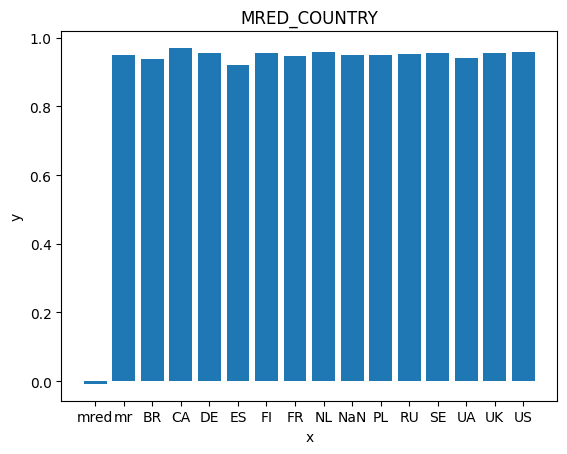

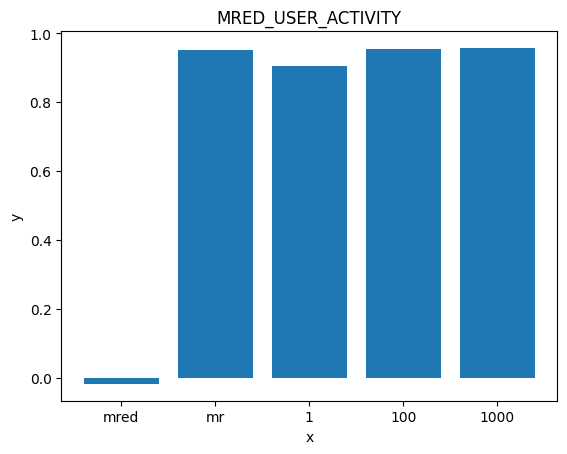

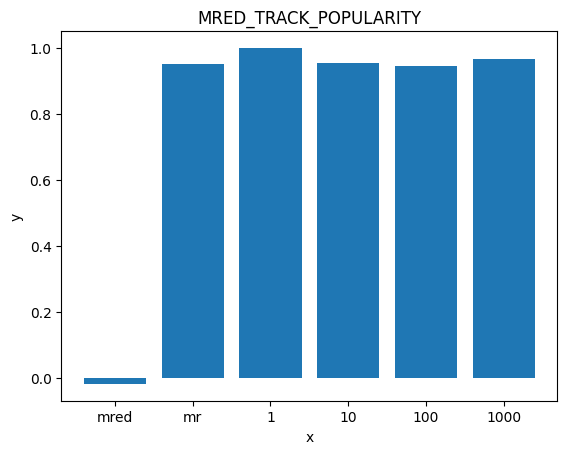

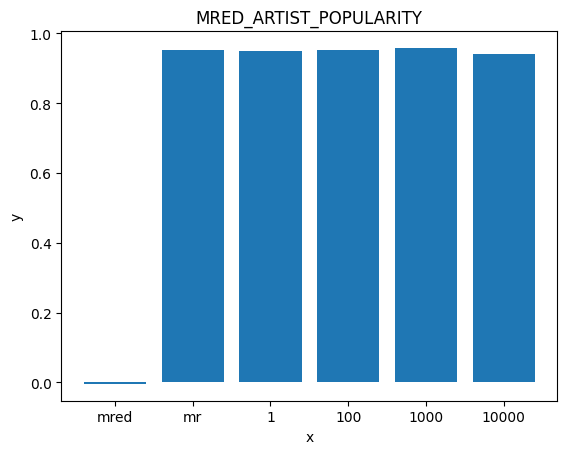

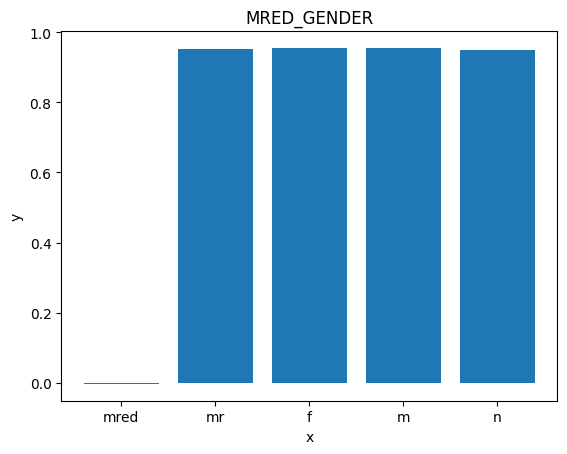

In [35]:
%%time
cdf = EvalRSReclist(
    dataset=dataset,
    model_name="MatrixFactorization",
    predictions=mf_predictions_df,
    logger=LOGGER.LOCAL,
    metadata_store=METADATA_STORE.LOCAL,
    similarity_model=similarity_model,
)

# run reclist
cdf(verbose=True)

Runs the evaluation code: remember, if LIMIT is not 0, your submission won't be uploaded but the loop may still be useful for you to debug / iterate locally_

## Two-tower architecture

A Two-Tower Model consists of item (candidate) and user (query) encoder towers. The model learns representations (embeddings) for user and candidate items separately and user-item affinity is computed by dot product between the output of the towers. Differently from Matrix Factorization, multiple user/query and item features can be used for more accurate recommendations.

<img src="./images/TwoTower.png"  width="30%">

Image Adapted from: [Off-policy Learning in Two-stage Recommender Systems](https://dl.acm.org/doi/abs/10.1145/3366423.3380130)

In [36]:
class MyTwoTowerModel(MyRetrievalModel):
        
    
    def get_model(self):                   
        query_schema = self.schema.select_by_tag(Tags.USER)
        query_inputs = mm.InputBlockV2(query_schema,
                                   categorical=mm.Embeddings(
                                        query_schema.select_by_tag(Tags.CATEGORICAL),
                                        l2_batch_regularization_factor=self.hparams['embeddings_l2_reg'],
                                        infer_dim_fn=partial(
                                            schema_utils.infer_embedding_dim,
                                            multiplier=self.hparams['tt_infer_embedding_sizes_multiplier']
                                        ),
                                       sequence_combiner="mean",
                                    ),
                                  )
        
        query = mm.Encoder(query_inputs, 
                           mm.MLPBlock(
                                self.hparams['tt_mlp_layers'],
                                activation=self.hparams['tt_mlp_activation'],
                                no_activation_last_layer=True,    
                                dropout=self.hparams['tt_mlp_dropout'],                
                                kernel_regularizer=regularizers.l2(self.hparams['tt_mlp_l2_reg']),
                                bias_regularizer=regularizers.l2(self.hparams['tt_mlp_l2_reg']),
                            ))
        
        candidate_schema = self.schema.select_by_tag(Tags.ITEM)
        candidate_inputs = mm.InputBlockV2(candidate_schema,
                                   categorical=mm.Embeddings(
                                        candidate_schema.select_by_tag(Tags.CATEGORICAL),
                                        l2_batch_regularization_factor=self.hparams['embeddings_l2_reg'],
                                        infer_dim_fn=partial(
                                            schema_utils.infer_embedding_dim,
                                            multiplier=self.hparams['tt_infer_embedding_sizes_multiplier']
                                        ),
                                       sequence_combiner="mean",
                                    ),
                                  )
        candidate = mm.Encoder(candidate_inputs, 
                               mm.MLPBlock(
                                    self.hparams['tt_mlp_layers'],
                                    activation=self.hparams['tt_mlp_activation'],
                                    no_activation_last_layer=True,    
                                    dropout=self.hparams['tt_mlp_dropout'],                
                                    kernel_regularizer=regularizers.l2(self.hparams['tt_mlp_l2_reg']),
                                    bias_regularizer=regularizers.l2(self.hparams['tt_mlp_l2_reg']),
                                ))

        retrieval_output = self.get_retrieval_output()
        model = mm.TwoTowerModelV2(query, candidate, outputs=retrieval_output)


        return model

Next cell builds a Two-Tower model. If you want to use the text lyrics pre-trained embeddings as an additional item feature, you can set `pretrained_embeddings=song_lyrics_embedding_matrix` as commented below

In [37]:
tt_model = MyTwoTowerModel(
    user_ids_mapping_df,
    track_ids_mapping_df,
    pretrained_embeddings=None,
    # Uncomment this line if you want to use the track lyrics pre-trained embeddings to
    # as a feature in the model
    #pretrained_embeddings=song_lyrics_embedding_matrix 
    
    # Training hparams
    epochs=5,
    train_batch_size=8192,
    lr=2e-3,
    lr_decay_steps=100,
    lr_decay_rate=0.97,
    label_smoothing=0.0,
    
    # Model hparams
    logq_correction_factor=0.0,
    embeddings_l2_reg=0.0,
    logits_temperature=1.8,
    tt_mlp_layers=[256,128],
    tt_mlp_activation="relu",
    tt_mlp_dropout=0.3,
    tt_mlp_l2_reg=5e-5,
    tt_infer_embedding_sizes_multiplier=2.0
)

In [38]:
# TODO: Investigate why the multi-hot features are causing error on topk encoder export
train_ds.schema = train_ds.schema.without(["social_tags_value", "emotion_tags_value"])

In [39]:
%%time
tt_model.train(train_ds)

Building the model
RetrievalModelV2(
  (_should_compute_train_metrics_for_batch): <tf.Variable 'should_compute_train_metrics_for_batch:0' shape=() dtype=bool, numpy=True>
  (blocks): _TupleWrapper((ParallelBlock(
    (parallel_layers): Dict(
      (query): Encoder(
        (blocks): List(
          (0): ParallelBlock(
            (_aggregation): ConcatFeatures()
            (parallel_layers): Dict(
              (categorical): ParallelBlock(
                (parallel_layers): Dict(
                  (user_id): EmbeddingTable(
                    (features): Dict(
                      (user_id): ColumnSchema(name='user_id', tags={<Tags.ID: 'id'>, <Tags.USER: 'user'>, <Tags.CATEGORICAL: 'categorical'>}, properties={'num_buckets': None, 'freq_threshold': 0.0, 'max_size': 0.0, 'cat_path': '/data/evalrs_2023_dataset_preproc/categories/unique.user_id.parquet', 'embedding_sizes': {'cardinality': 29725.0, 'dimension': 512.0}, 'domain': {'min': 0, 'max': 29724, 'name': 'user_id'}}, dtype=DType

Epoch 1/5


2023-08-01 02:27:37.895101: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


839/839 [==============================] - 201s 230ms/step - loss: 7.4602 - recall_at_20: 0.0543 - mrr_at_20: 0.0129 - regularization_loss: 0.0386 - loss_batch: 7.4600
Epoch 2/5
839/839 [==============================] - 61s 71ms/step - loss: 6.6048 - recall_at_20: 0.2045 - mrr_at_20: 0.0645 - regularization_loss: 0.0441 - loss_batch: 6.6050
Epoch 3/5
839/839 [==============================] - 51s 60ms/step - loss: 6.2963 - recall_at_20: 0.2678 - mrr_at_20: 0.0980 - regularization_loss: 0.0484 - loss_batch: 6.2959
Epoch 4/5
839/839 [==============================] - 52s 60ms/step - loss: 6.1039 - recall_at_20: 0.3066 - mrr_at_20: 0.1220 - regularization_loss: 0.0528 - loss_batch: 6.1033
Epoch 5/5
839/839 [==============================] - 48s 56ms/step - loss: 5.9663 - recall_at_20: 0.3272 - mrr_at_20: 0.1374 - regularization_loss: 0.0565 - loss_batch: 5.9656
Preparing retrieval model for prediction


/usr/local/lib/python3.8/dist-packages/merlin/dataloader/loader_base.py:591: UserWarning: This `schema` property is deprecated and will be removed in a future version. Please use either the `input_schema` or `output_schema` property instead.
  warnings.warn(


INFO:tensorflow:Assets written to: /tmp/tmp6544i68s/assets


INFO:tensorflow:Assets written to: /tmp/tmp6544i68s/assets


Caching users transformed features
Training completed!
CPU times: user 10min 53s, sys: 48.7 s, total: 11min 42s
Wall time: 9min 32s


In [40]:
%%time
tt_predictions_df = tt_model.predict(events_test_df[['user_id']])
tt_predictions_df

Start prediction
# users: 29722
Predicting Top-100 items for test users


2023-08-01 02:37:09.322787: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Converting user ids and predicted item ids to the original ids
Finish prediction
CPU times: user 3.41 s, sys: 171 ms, total: 3.58 s
Wall time: 3.11 s


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
50967444,19310,19315,29449681,314437,11285148,19353,96656,18097518,96662,94257,...,11263847,280589,280587,926040,9449257,19059517,159787,67792,697193,19697265
50900118,19726076,19726075,12672683,19959795,18268416,19170202,779986,16685899,17585675,172117,...,142069,63565,21894616,1635734,29455036,518973,1635733,941821,21897493,1102461
50086315,3051084,727747,416085,761763,382252,488836,607534,8167520,786290,570331,...,632342,2265859,419231,900557,886310,12590202,211105,1689276,950850,336750
50085736,102641,102642,102659,102647,28528,102648,34965,128188,13268005,7961917,...,667604,207419,7302926,67550,7996606,1139070,4404135,8062057,296501,529416
50083088,95974,95973,78161,754575,240869,92578,94352,94590,243270,94596,...,140812,345504,93495,143619,98676,11447688,95980,1324767,81272,483960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15067,23962088,64323,2791808,9213567,1082173,22786536,1082171,497711,29526681,8690872,...,718959,475998,799366,23245999,1004586,755856,491583,764130,1151548,1751219
14308,19486,155461,190992,155462,99681,2509518,38338,11176853,30103,153059,...,153194,98274,129388,38337,183170,10405664,208959,701575,184384,51570
12619,18265065,121454,877502,29453002,877309,877308,497711,497383,134656,193281,...,3760746,154282,470457,18573594,3063166,129619,2067835,718270,24495849,10628831


In [41]:
compute_recall(tt_predictions_df)

0.027218895094542762

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

stats:{'num_users': 29722, 'max_items': 1, 'min_items': 1}

HIT_RATE:0.027218895094542762

MRR:0.0015844976107347265

MRED_COUNTRY:{'mred': -0.005295568680057491, 'mr': 0.9721409296491962, 'BR': 0.9774358974358974, 'CA': 
0.9777777777777777, 'DE': 0.9695613249776186, 'ES': 0.975609756097561, 'FI': 0.9772151898734177, 'FR': 
0.9621212121212122, 'NL': 0.9809264305177112, 'NaN': 0.9706362153344209, 'PL': 0.9716636197440585, 'RU': 
0.9771293375394322, 'SE': 0.9616724738675958, 'UA': 0.9833333333333333, 'UK': 0.9733096085409253, 'US': 
0.9756191950464397}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_USER_ACTIVITY:{'mred': -0.012354073600659765, 'mr': 0.9727811049054572, 1: 0.9424920127795527, 100: 
0.974764353041988, 1000: 0.9775709854450012}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_TRACK_POPULARITY:{'mred': -0.014173503314653058, 'mr': 0.9727811049054572, 1: 0.9724770642201835, 10: 
0.9587928735910799, 100: 0.9891608391608392, 1000: 0.9988031119090365}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_ARTIST_POPULARITY:{'mred': -0.015556087082570058, 'mr': 0.9727811049054572, 1: 0.9506545820745217, 100: 
0.951885767499612, 1000: 0.9741259313845901, 10000: 0.9906387665198237}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_GENDER:{'mred': -0.002707459633229381, 'mr': 0.9727811049054572, 'f': 0.9757794382891007, 'm': 
0.9754122938530735, 'n': 0.9702882483370289}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

BEING_LESS_WRONG:0.3040198087692261

                                EvalRSReclist                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                   Type ┃ Description  ┃                             Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                  stats │              │                                  { │
│                        │              │                "num_users": 29722, │
│                        │              │                    "max_items": 1, │
│                        │              │                     "min_items": 1 │
│                        │              │                                  } │
│               HIT_RATE │              │                             0.0272 │
│                    MRR │              │                             0.0016 │
│           MRED_COUNTRY │              │                                  { │
│                        │              │     "mred": -0.005295568680057491, │
│                        │              │          "mr": 0.9721409296491962, │
│                        │              │          "BR": 0.9774358974358974, │
│                        │              │          "CA": 0.9777777777777777, │
│                        │              │          "DE": 0.9695613249776186, │
│                        │              │           "ES": 0.975609756097561, │
│                        │              │          "FI": 0.9772151898734177, │
│                        │              │          "FR": 0.9621212121212122, │
│                        │              │          "NL": 0.9809264305177112, │
│                        │              │         "NaN": 0.9706362153344209, │
│                        │              │          "PL": 0.9716636197440585, │
│                        │              │          "RU": 0.9771293375394322, │
│                        │              │          "SE": 0.9616724738675958, │
│                        │              │          "UA": 0.9833333333333333, │
│                        │              │          "UK": 0.9733096085409253, │
│                        │              │           "US": 0.9756191950464397 │
│                        │              │                                  } │
│     MRED_USER_ACTIVITY │              │                                  { │
│                        │              │     "mred": -0.012354073600659765, │
│                        │              │          "mr": 0.9727811049054572, │
│                        │              │           "1": 0.9424920127795527, │
│                        │              │          "100": 0.974764353041988, │
│                        │              │         "1000": 0.9775709854450012 │
│                        │              │                                  } │
│  MRED_TRACK_POPULARITY │              │                                  { │
│                        │              │     "mred": -0.014173503314653058, │
│                        │              │          "mr": 0.9727811049054572, │
│                        │              │           "1": 0.9724770642201835, │
│                        │              │          "10": 0.9587928735910799, │
│                        │              │         "100": 0.9891608391608392, │
│                        │              │         "1000": 0.9988031119090365 │
│                        │              │                                  } │
│ MRED_ARTIST_POPULARITY │              │                                  { │
│                        │              │     "mred": -0.015556087082570058, │
│                        │              │          "mr": 0.9727811049054572, │
│                        │              │           "1": 0.9506545820745217, │
│                        │              │          "100": 0.951885767499612, │
│                        │              │        "1000": 0.9741259313845901, │
│                        │              │        "

CPU times: user 1.4 s, sys: 552 ms, total: 1.95 s
Wall time: 1.41 s


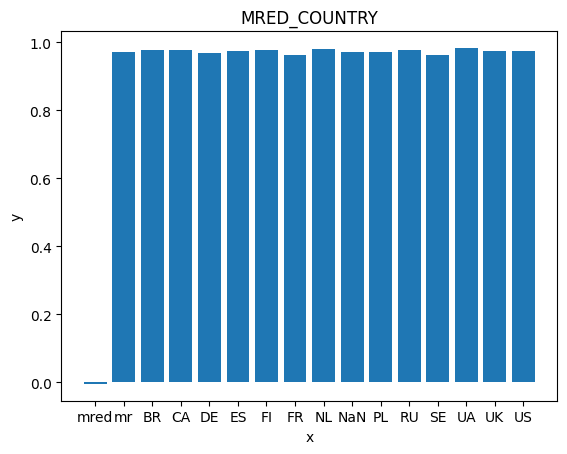

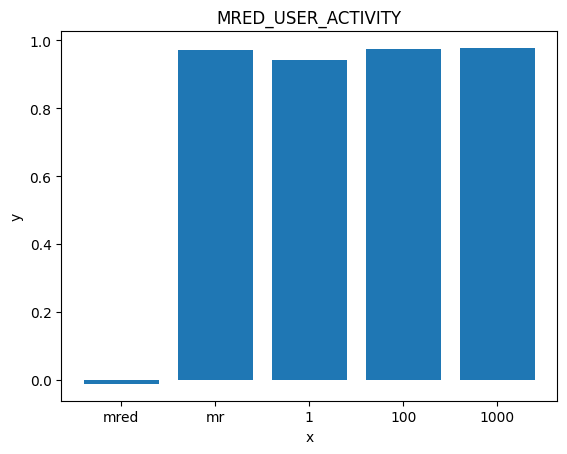

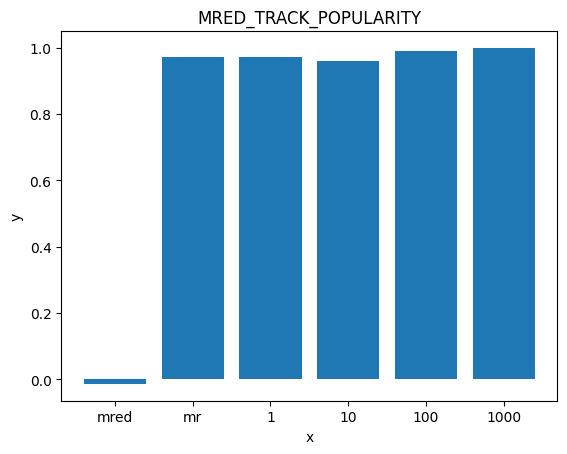

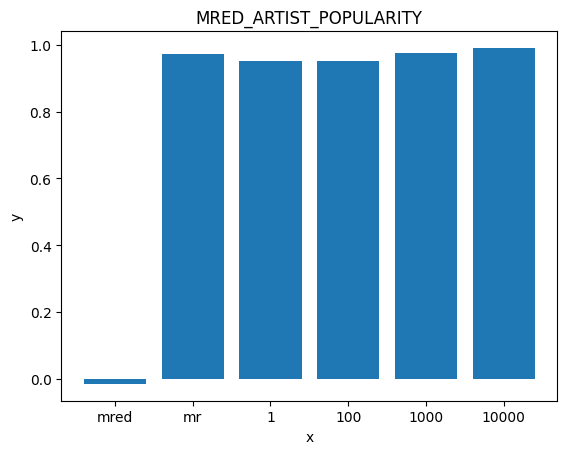

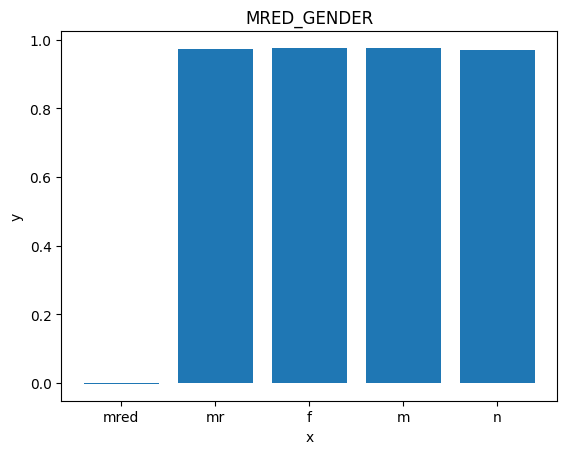

In [43]:
%%time
cdf = EvalRSReclist(
    dataset=dataset,
    model_name="Two-Tower",
    predictions=tt_predictions_df,
    logger=LOGGER.LOCAL,
    metadata_store=METADATA_STORE.LOCAL,
    similarity_model=similarity_model,
)

# run reclist
cdf(verbose=True)

In [44]:
export_preds(tt_predictions_df, "tt_test_preds.parquet")

## Conclusion

In this notebook you have learned how build retrieval models (MF, Two-Tower) with the [Merlin](https://github.com/NVIDIA-Merlin/) open-source framework for the EvalRS hackaton on the LastFM dataset. 
Feel free to try improving the accuracy by feature engineering, modeling changes or hypertuning.